# Stéréo recontruction

## Test 19/06/2024

In [1]:
import cv2
import numpy as np

In [2]:
img1 = cv2.imread('media/tasse190624A_L.jpg')
img2 = cv2.imread('media/tasse190624A_R.jpg')

In [20]:
fx, fy, cx, cy = 300.0, 1000.0, 1.0, 1.0
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])  # Camera intrinsic matrix

In [21]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

In [22]:
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K, mask=mask)

In [23]:
# Build the projection matrices for the two cameras
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R, t))

# Convert the projection matrices to the camera coordinate system
P1 = K @ P1
P2 = K @ P2

# Triangulate the 3D points
points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
points_3D = points_4D / points_4D[3]  # Convert from homogeneous to Cartesian coordinates
points_3D = points_3D[:3, :].T

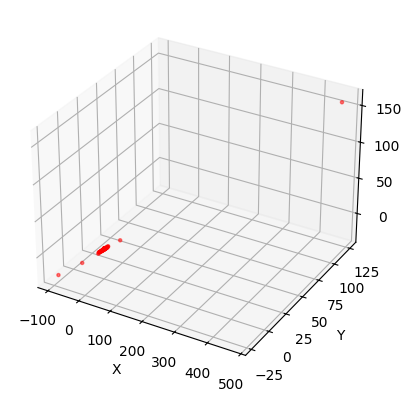

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)

# Configure the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()